In [88]:
import matplotlib.pyplot as plt
from glob import glob
from argparse import Namespace
from itertools import groupby
import data.eval as eval
import re
from collections import defaultdict
import pandas as pd

In [89]:
gold_files = glob('generated_samples/**/Gold/**/*.jsonl', recursive=True)
eval_files = glob('generated_samples/**/Eval/**/*.jsonl', recursive=True)

grouped_gold = groupby(sorted(gold_files, key=lambda x: x.split('/')[1]), lambda x: x.split('/')[1])

In [95]:
def get_model_df(grouped_results):
    results_arr = []

    for model, files in grouped_results:
        for file in files:
            epoch = re.match(r'.*_(?P<epoch>\d+)_.*', file).group(1)

            args = Namespace(
                results_path=file,
                dataset_path='data/instruct_cochrane_gold.json',
                label_field_name='gold_label',
                lines=True,
                rogue_tokens=True
            )

            results_df, _ = eval.main(args)
            results_df['model'] = model
            results_df['epoch'] = int(epoch)
            results_df.drop(index=['weighted avg'], columns='support', inplace=True)

            results_df.set_index(['model', 'epoch', results_df.index], inplace=True)

            results_arr.append(results_df)

    return pd.concat(results_arr).sort_index()

grouped_gold = groupby(sorted(gold_files, key=lambda x: x.split('/')[1]), lambda x: x.split('/')[1])
grouped_eval = groupby(sorted(eval_files, key=lambda x: x.split('/')[1]), lambda x: x.split('/')[1])

gold_df = get_model_df(grouped_gold)
eval_df = get_model_df(grouped_eval)

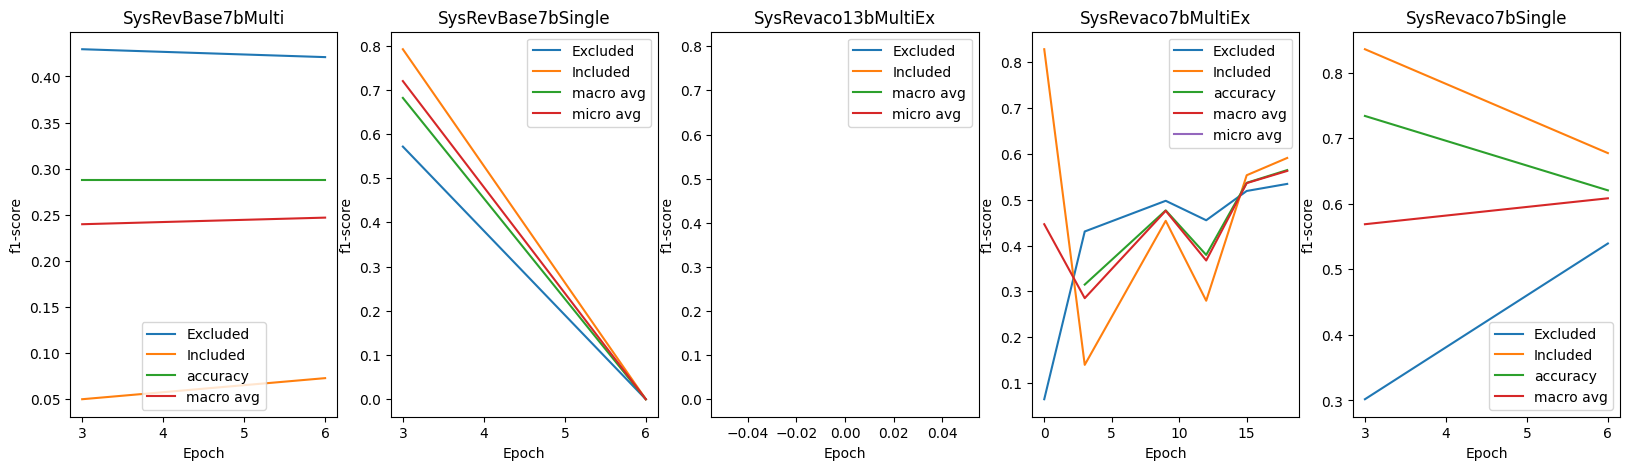

In [97]:
def plot_results(results_df, metric='f1-score'):
    models = results_df.index.get_level_values(0).unique()

    _, axs = plt.subplots(1, len(models), figsize=(20, 5))

    for i, model in enumerate(models):
        gold_df.xs(model).unstack(level=1)[metric].plot(ax=axs[i])
        axs[i].set_title(model)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(metric)

    plt.show()

plot_results(gold_df)